Automatically created module for IPython interactive environment
n_digits: 10, 	 n_samples 1797, 	 n_features 64
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.24s	69432	0.602	0.650	0.625	0.465	0.598	0.146
random   	0.17s	69694	0.669	0.710	0.689	0.553	0.666	0.147
PCA-based	0.04s	70804	0.671	0.698	0.684	0.561	0.668	0.118
__________________________________________________________________________________


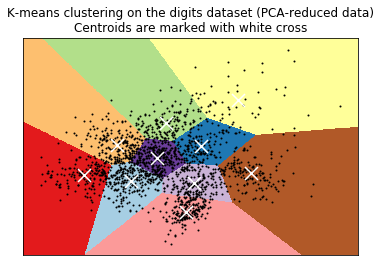

In [1]:
print(__doc__)

from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

Automatically created module for IPython interactive environment
Estimated number of clusters: 3
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.883
Silhouette Coefficient: 0.626


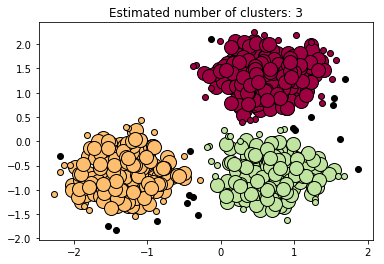

In [2]:
print(__doc__)

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [3]:
import os
path_images = "/home/srmilab/Nicolas/MineriaDatos/"

path_class_1 = path_images + "n02111889-Samoyed"
filenames_class_1 = os.listdir(path_class_1)

from skimage import io


FileNotFoundError: [Errno 2] No such file or directory: '/home/srmilab/Nicolas/MineriaDatos/n02111889-Samoyed'

In [9]:
filenames_class_1

['n02111889_853.jpg',
 'n02111889_4353.jpg',
 'n02111889_1438.jpg',
 'n02111889_3409.jpg',
 'n02111889_4967.jpg',
 'n02111889_1402.jpg',
 'n02111889_14064.jpg',
 'n02111889_3400.jpg',
 'n02111889_2952.jpg',
 'n02111889_17211.jpg',
 'n02111889_5463.jpg',
 'n02111889_6545.jpg',
 'n02111889_6622.jpg',
 'n02111889_1264.jpg',
 'n02111889_4484.jpg',
 'n02111889_16116.jpg',
 'n02111889_8613.jpg',
 'n02111889_2544.jpg',
 'n02111889_17383.jpg',
 'n02111889_6333.jpg',
 'n02111889_15995.jpg',
 'n02111889_1716.jpg',
 'n02111889_14413.jpg',
 'n02111889_6041.jpg',
 'n02111889_2030.jpg',
 'n02111889_5778.jpg',
 'n02111889_771.jpg',
 'n02111889_16414.jpg',
 'n02111889_16434.jpg',
 'n02111889_1255.jpg',
 'n02111889_3566.jpg',
 'n02111889_4679.jpg',
 'n02111889_1451.jpg',
 'n02111889_6183.jpg',
 'n02111889_373.jpg',
 'n02111889_10734.jpg',
 'n02111889_1735.jpg',
 'n02111889_16090.jpg',
 'n02111889_7491.jpg',
 'n02111889_15020.jpg',
 'n02111889_2914.jpg',
 'n02111889_12771.jpg',
 'n02111889_5602.jpg',
 '

In [6]:
import os

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import os
path_images = "/Users/CamiloCB/Downloads/MineriaDatos/Dog/"

path_class_1 = path_images + "n02111889-Samoyed"
filenames_class_1 = os.listdir(path_class_1)

from skimage import io


filename = os.path.join(path_class_1 + "/" + filenames_class_1[0])
camera = io.imread(filename)



FileNotFoundError: [Errno 2] No such file or directory: '/Users/CamiloCB/Downloads/MineriaDatos/Dog/n02111889-Samoyed'

In [24]:
def obtain_data(filename):
    path_images = "/home/srmilab/Nicolas/MineriaDatos/Dogs/"

    path_class_1 = path_images + filename
    filenames_class_1 = os.listdir(path_class_1)
    
    train_class_1 = []
    for i in filenames_class_1:
        filename = os.path.join(path_class_1 + "/" + i)
        camera = io.imread(filename)
        train_class_1.append(camera)
    train_class_1 = np.asarray(train_class_1)
    train_class_1 = np.reshape(train_class_1,(len(train_class_1), train_class_1.shape[1]*train_class_1.shape[2]*train_class_1.shape[3]))
    return train_class_1

In [26]:
filenames_dogs = os.listdir("/home/srmilab/Nicolas/MineriaDatos/Dogs")

In [27]:
filenames_dogs

['n02116738-African_hunting_dog',
 'n02111889-Samoyed',
 'n02112350-keeshond',
 'n02115913-dhole',
 'n02112137-chow',
 'n02113624-toy_poodle',
 'n02115641-dingo',
 'n02113023-Pembroke',
 'n02113712-miniature_poodle',
 'n02113186-Cardigan',
 'n02113978-Mexican_hairless',
 'n02113799-standard_poodle',
 'n02112706-Brabancon_griffon',
 'n02112018-Pomeranian']

In [4]:
train_label = np.zeros(len(train_dogs))

index_class_0 = len(obtain_data(filenames_dogs[0]))
index_class_1 = len(obtain_data(filenames_dogs[1]))
index_class_2 = len(obtain_data(filenames_dogs[2]))
                    
train_label[:index_class_0] = 0
train_label[index_class_0: index_class_0 + index_class_1] = 1
train_label[index_class_0 + index_class_1: index_class_0 + index_class_1 + index_class_2] = 2


NameError: name 'train_dogs' is not defined

In [75]:
train_label

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [8]:
train_dogs.shape

NameError: name 'train_dogs' is not defined

In [61]:
def asoc(breed_array, cluster_array):
    result = []
    for i in range(len(breed_array)):
        result.append((breed_array[i], cluster_array[i], moda(breed_array[i], cluster_array[i])))
    return result

def moda(array, id):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-61-e0c9a2ea463b>, line 8)

In [62]:
from scipy.stats import mode
def test_acc(cat_pred, labels):
    real_pred = np.zeros_like(cat_pred)
    for cat in range(len(cat_pred)):
        idx = cat_pred == cat
        lab = labels[idx]
        if len(lab) == 0:
            continue
        real_pred[cat_pred == cat] = mode(lab).mode[0]
    return np.mean(real_pred == labels)
        

In [20]:
train_class_1 = np.reshape(train_class_1,(len(train_class_1), train_class_1.shape[1]*train_class_1.shape[2]*train_class_1.shape[3]))

In [22]:
train_class_1.shape

(197, 58800)

In [79]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=3, random_state=2).fit(train_dogs)

In [80]:
test_acc(kmeans.labels_, train_label)

0.46215139442231074